<a href="https://colab.research.google.com/github/HopeJesus55/petrsu-machine-learning/blob/main/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Бэггинг**


Идея бэггинга (bagging, bootstrap aggregation) заключается в следующем:

Выберем из обучающей выборки $n$ примеров. Будем выбирать примеры равновероятно, с повторением. Получим новую выборку $X^1$, в которой некоторых элементов исходной выборки не будет, а какие-то могут войти несколько раз. С помощью некоторого алгоритма $b$ обучим на этой выборке модель $b_1$($x$)=$b(x,X^1)$. Повторим процедуру: сформируем вторую выборку $X^2$ из $n$ элементов с возвращением и с помощью того же алгоритма обучим на ней модель $b_2$($x$)=$b(x,X^2)$. Повторив процедуру $k$ раз, получим $k$ моделей, обученных на $k$ выборках. Чтобы получить одно предсказание, усредним предсказания всех моделей:


\begin{align}
        a(x) = \frac{1}{k} (b_1(x)+⋯+b_k(x)).
    \end{align}



Процесс генерации подвыборок с помощью семплирования с возвращением называется бутстрепом (bootstrap), а модели $b_1(x)$,…,$b_k(x)$ часто называют базовыми алгоритмами. Модель $a(x)$ называется ансамблем этих алгоритмов.

**Постановка задачи:** 

Пусть наша целевая зависимость $f(x)$ задаётся как


\begin{align}
        f(x)=xsinx,
    \end{align}

и к ней добавляется нормальный шум $ε$∼$N(0,9)$.


**Описание структуры исходных данных:**

Наши обучающие и тестовые примеры будут состоять из зашумлённых значений целевой функции $f(x)$, определённой выше. В качестве шума добавляется нормальный шум с нулевым средним и дисперсией σ$^2$, равной во всех дальнейших примерах 9. Такое большое значение шума задано для того, чтобы задача была достаточно сложной для классификатора, который будет на этих данных учиться и тестироваться.

**Описание используемых функций и их параметров:**

          def __init__(self, max_depth: int, max_samples: int, n_estimators: int)
Конструктор класса модели для обучения.


*   max_depth - максимальная глубина дерева
*   max_samples - максимальное количество случайных семплов
*   n_estimators - статистическая оценка 
          def generate_data(n_samples, noise, n_noise_samples)

Генерирует данные и добавляет шум.


*   n_samples - количество семплов в выборке
*   noise - параметр шума
*   n_noise_samples - количество семплов случайного шума



          def train_classifier_on_random_subset(clf_class, 
          parameters, n_train_samples, noise)
Обучает модель на случайно сгенерированном сете данных.
*   clf_class - классификатор для обучения
*   parameters - параметры 
*   n_train_samples - размер семпла
*   noise - параметр шума




          def plot_many_predictions(axs, x_ticks, clf_class, 
                          parameters, n_tries, n_train_samples,
                          title)

Рисует граф предсказаний модели.
*   axs - область отражения графика
*   x_ticks - используется для получения текущих местоположений тиков и меток оси x
*   clf_class - классификатор для обучения
*   parameters - параметры 
*   n_tries - количество итераций
*   n_train_samples - размер семпла
*   title - подпись графика


          def get_predictions(classifiers, n_tries, noise, n_train_samples, 
                              n_test_samples, n_noise_samples)

Получает предсказания модели.
*   classifiers - классифицирует данные по сетам классов
*   n_tries - количество итераций
*   noise - параметр шума 
*   n_train_samples - количество семплов случайных подмножеств для обучения деревьев
*   n_test_samples - размер случайного тестового подмножества точек
*   n_noise_samples - количество семплов случайного шума


          def get_bias_variance(results)

Получает значения дилеммы смещения–дисперсии.
*   results - итоговые предсказания модели

**Решение задачи:**

In [4]:
#Подключаем библиотеки
from typing import Tuple, TypeVar, Dict, Any, List

from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import cauchy
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#Библиотеки классов для машинного обучения
SklearnClass = TypeVar("SklearnClass") # The class itself (e.g. DecisionTreeRegressor)
SklearnModel = TypeVar("SklearnModel") # A class instance (e.g. DecisionTreeRegressor(max_depth=1))

In [5]:
#Для случайной генерации семплов
random_seed = 42
np.random.seed(random_seed)

In [47]:
#Выставляем цвета для графов.
deep_grey = '#3B4856'
sky_blue = '#348FEA'
marine_green = '#4CB9C0'
grass_green = '#97C804'
medium_yellow = '#FFC100'
sicilian_orange = '#E06A27'
fuchsia_pink = '#C81D6B'
saturated_violet = '#5002A7'
navy_blue = '#292183'
cool_white = '#F5FBFF'

 Пример семпла из таких данных:

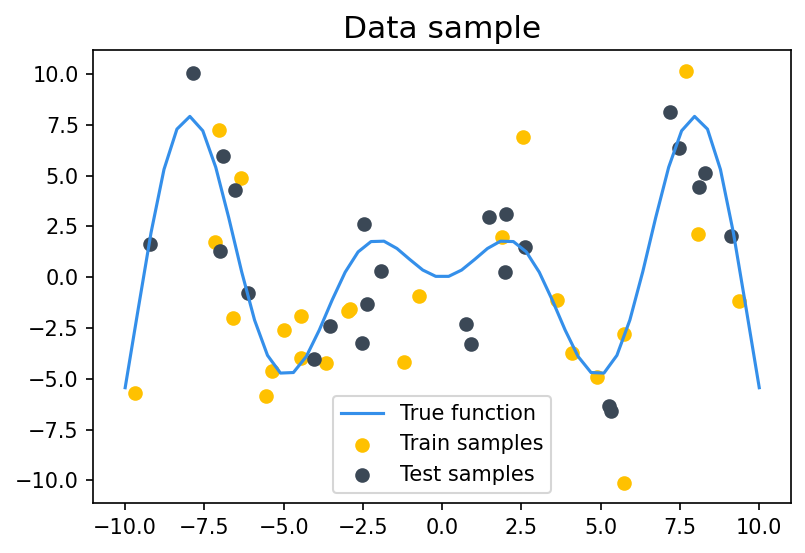

In [49]:
#Заданная нами функция - х*sin(x)
def f(x: np.ndarray) -> np.ndarray:
  return x * np.sin(x)

#Генерируем наши данные и добавляем шум
def generate_data(n_samples: int = 50, noise: float = 3, n_noise_samples: int = 1) -> Tuple[np.ndarray, np.ndarray]:
  x = np.random.rand(n_samples) * 20 - 10
  x = np.sort(x)

  y = np.zeros((n_samples, n_noise_samples))
  for i in range(n_noise_samples):
      y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)

  return x.reshape((n_samples, 1)), y.squeeze()

x, y = generate_data(noise=3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

plt.figure(dpi=150)
plt.title('Data sample', fontsize=15)
plt.plot(np.linspace(-10, 10), f(np.linspace(-10, 10)), color=sky_blue, label="True function")
plt.scatter(x_train, y_train, color=medium_yellow, label="Train samples")
plt.scatter(x_test, y_test, color=deep_grey, label="Test samples")
plt.legend()
plt.show()

Попробуем посмотреть, как выглядят предсказания бэггинга над решающими деревьями в зависимости от обучающей выборки. Обучим решающие деревья 100 раз на различных случайных семплах размера 20. Возьмём также бэггинг над 10 решающими деревьями глубины 7 в качестве базовых классификаторов и тоже 100 раз обучим его на случайных выборках размера 20.

Поскольку бэггинг специально семплирует себе случайные подмножества, мы будем передавать ему на вход 10 000 случайных примеров, из которых он 10 раз (столько деревьев мы включим в ансамбль) насемплирует обучающие подмножества размера 20. 



In [50]:
class BaggingOnTrees(BaggingRegressor):
  def __init__(self, max_depth: int, max_samples: int, n_estimators: int):
    base_estimator = DecisionTreeRegressor(max_depth=max_depth)
    super().__init__(base_estimator=base_estimator, max_samples=max_samples, n_estimators=n_estimators)

In [51]:
#Обучаем модель на случайно сгенерированном сете данных
def train_classifier_on_random_subset(clf_class: SklearnClass, parameters: Dict[str, Any], 
                                      n_train_samples: int = 20, noise: float = 3) -> Tuple[SklearnModel, List[np.ndarray]]:

  x_train, y_train = generate_data(n_samples=n_train_samples, noise=noise)
  clf = clf_class(**parameters)
  clf.fit(x_train, y_train)
  return clf, x_train, y_train

Если изобразить предсказания обученной модели на каждой из 100 итераций, то можно увидеть примерно такую картину:

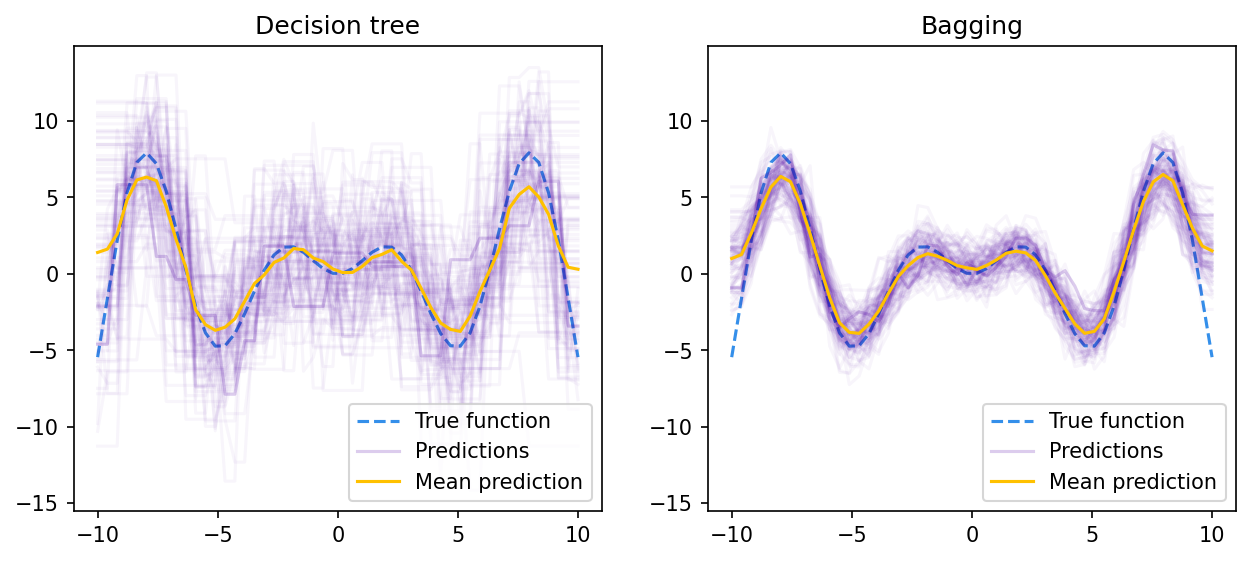

In [52]:
#Отрисовывем предсказания модели
def plot_many_predictions(axs, x_ticks: np.ndarray, clf_class: SklearnClass, 
                          parameters: Dict[str, Any], n_tries: int, n_train_samples: int,
                          title: str) -> None:
  
  axs.plot(x_ticks, f(x_ticks), color=sky_blue, label="True function", linestyle="--")
  np.random.seed(random_seed)
  predictions = []
  for j in range(n_tries):
    clf, _, _ = train_classifier_on_random_subset(
      clf_class=clf_class, parameters=parameters, noise=3,
      n_train_samples=n_train_samples
    )
    prediction = clf.predict(x_ticks[:, None])
    predictions.append(prediction)
    if j == 0:
      axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.2, label="Predictions")
    else:
      axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.04)

  axs.plot(x_ticks, np.mean(np.stack(predictions), axis=0), label="Mean prediction", color=medium_yellow)
  axs.set_title(title)
  axs.legend(loc="lower right")

#На каждой из 100 итераций
n_tries = 100
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = 1, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4), dpi=150, sharey=True)
fig.subplots_adjust(top=0.9)

#Предсказания для отдельного дерева решений
plot_many_predictions(
    axs=ax[0], x_ticks=x_ticks, clf_class=DecisionTreeRegressor, 
    parameters={"max_depth": 7}, 
    n_tries=n_tries, n_train_samples=20, 
    title="Decision tree"
)

#Предсказания для бэггинга
plot_many_predictions(
    axs=ax[1], x_ticks=x_ticks, clf_class=BaggingOnTrees,
    parameters={"max_samples": 20, "n_estimators": 10, "max_depth": 7}, 
    n_tries=n_tries, n_train_samples=10000,
    title="Bagging",
)
ax[1].yaxis.set_tick_params(labelbottom=True)

plt.show()

По этому рисунку видно, что общая дисперсия предсказаний в зависимости от обучающего множества у бэггинга значительно ниже, чем у отдельных деревьев, а в среднем предсказания деревьев и бэггинга не отличаются.

Чтобы подтвердить это наблюдение, мы можем изобразить смещение и разброс случайных деревьев и бэггинга в зависимости от максимальной глубины:

In [22]:
#Получаем результаты предсказаний
def get_predictions(
    classifiers: List[Tuple[SklearnClass, Dict[str, Any]]], 
    n_tries: int, noise: float, n_train_samples: int, 
    n_test_samples: int, n_noise_samples: int) -> List[Dict[int, Any]]:
  
  x_test, y_test = generate_data(n_samples=n_test_samples, 
                                 n_noise_samples=n_noise_samples, noise=noise)
  predictions = defaultdict(list)

  for i, (clf_class, parameters) in enumerate(classifiers):
    np.random.seed(random_seed)
    for j in tqdm(range(n_tries), desc=f"{clf_class.__name__}, {parameters}"):
      clf, _, _ = train_classifier_on_random_subset(
        clf_class=clf_class, parameters=parameters, 
        n_train_samples=n_train_samples,
        noise=noise
      )
      predictions[i].append(clf.predict(x_test))

  results = []
  for i, (clf_class, parameters) in enumerate(classifiers):
    results.append({
        "name": clf_class.__name__,
        "parameters": parameters,
        "predictions": np.stack(predictions[i]),
        "x_test": x_test,
        "y_test": y_test
    })
  
  return results

In [19]:
#Получаем значения bias_variance - дилеммы смещения–дисперсии
def get_bias_variance(results: Dict[str, Any]) -> pd.DataFrame:
  records = []
  for res in results:
    x_test, y_test = res["x_test"], res["y_test"]
    predictions = res["predictions"]
    bias = f(x_test).squeeze() - np.mean(predictions, axis=0)
    variance = np.var(predictions, axis=0)
    noise = np.var(y_test, axis=1)
    error = (predictions[..., None] - y_test[None]) ** 2

    records.append({
        "name": res["name"],
        "parameters": res["parameters"],
        "bias_sq": np.mean(bias ** 2),
        "variance": np.mean(variance),
        "noise": np.mean(noise),
        "error": np.mean(error),
        "decomposition": np.mean(bias ** 2 + variance + noise)
    })
    
  return pd.DataFrame.from_records(records)

In [25]:
#Посмотрим, как будет выглядеть bias-variance для бэггинга над деревьями в зависмости от глубины входящих в бэггинг деревьев
classifiers = [[BaggingOnTrees, {"max_samples": 500, "n_estimators": 10, "max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers, 
    n_tries=100, 
    n_test_samples=500, 
    n_train_samples=10000,
    n_noise_samples=300,
    noise=3
)

BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 1}: 100%|██████████| 100/100 [00:01<00:00, 52.09it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 2}: 100%|██████████| 100/100 [00:01<00:00, 50.90it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 3}: 100%|██████████| 100/100 [00:01<00:00, 50.34it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 4}: 100%|██████████| 100/100 [00:02<00:00, 47.41it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 5}: 100%|██████████| 100/100 [00:02<00:00, 47.33it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 6}: 100%|██████████| 100/100 [00:02<00:00, 46.08it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 7}: 100%|██████████| 100/100 [00:02<00:00, 43.51it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 8}: 100%|██████████| 100/100 [00:02<00:00, 44.71it/s]
BaggingO

**Визуализация результата:**

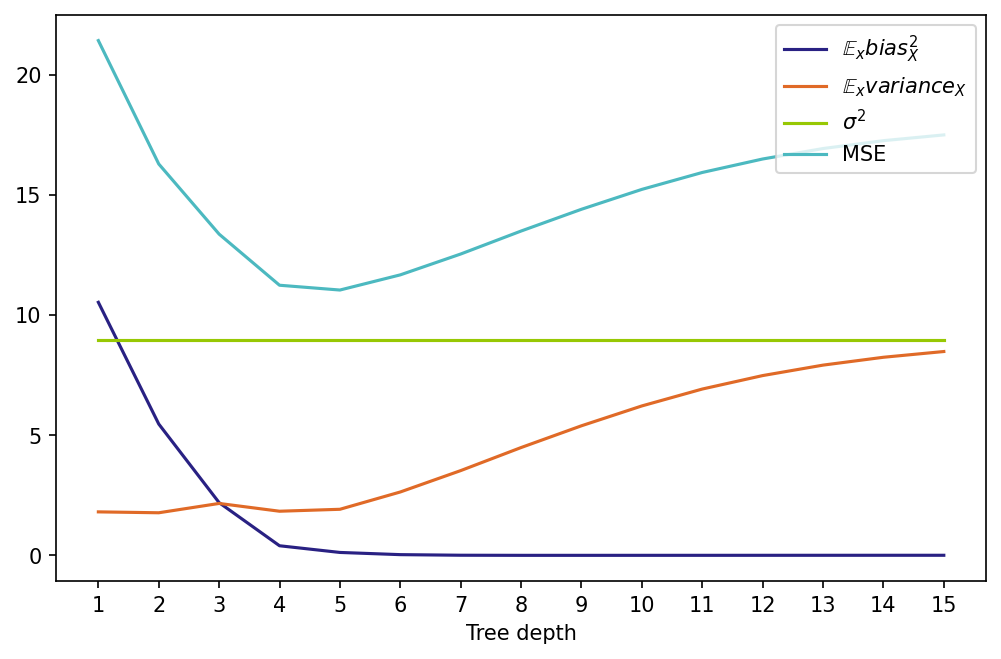

In [40]:
#Отобразим результаты на графике
bias_variance_trees = get_bias_variance(results)
depth = bias_variance_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

plot_bias_variance(bias_variance_trees, target_parameter_name="Tree depth",  target_parameter_values=depth)

Видно, что дисперсия у бэггинга гораздо ниже, чем была у единичных деревьев, а разброс выглядит почти так же. Для того, чтобы в этом точно убедиться, сравним смещения и разбросы деревьев и бэггинга на разных графиках.

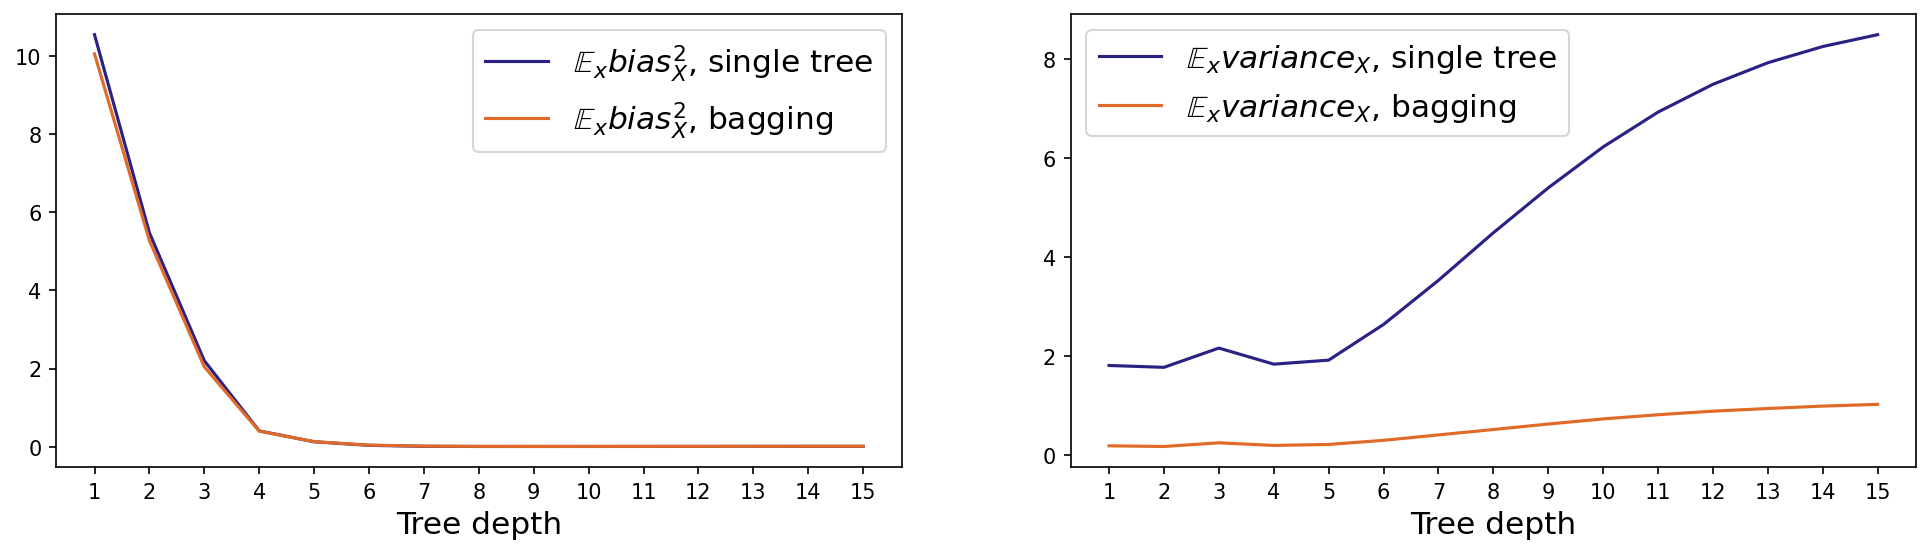

In [44]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(16, 4))

ax[0].set_xticks(depth)
#График единичного дерева
ax[0].plot(depth, bias_variance_trees.bias_sq, label="$\mathbb{E}_x bias_X^2$, single tree", color=navy_blue)
#График бэггинга
ax[0].plot(depth, bias_variance_bagging.bias_sq, label="$\mathbb{E}_x bias_X^2$, bagging", color=sicilian_orange)
ax[0].set_xlabel("Tree depth", fontsize=15)
ax[0].legend(fontsize=15)

ax[1].set_xticks(depth)
#График единичного дерева
ax[1].plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
#График бэггинга
ax[1].plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
ax[1].set_xlabel("Tree depth", fontsize=15)
ax[1].legend(fontsize=15)
plt.show()

На графике видно, как значительно бэггинг сократил дисперсию. На самом деле, дисперсия уменьшилась практически в 10 раз, что равняется числу базовых алгоритмов ($k$), которые бэггинг использовал для предсказания.

**Интерпретация результата:**  
Бэггинг позволяет улучшить точность и устойчивость работы алгоритмов машинного обучения, уменьшить дисперсию ошибки и эффект переобучения. Среди преимуществ можно отметить значительное увеличение точности предсказания ансамбля относительно базовых классификаторов (порядка 10-40%). Оно достигается за счет уменьшения разброса предсказаний базовых моделей при усреднении.

**Задания для самостоятельной работы:** 

$1)$ У Винни-Пуха есть 100 песенок (кричалок, вопелок, пыхтелок и сопелок). Каждый день он
выбирает и поёт одну из них равновероятно наугад. Одну и ту же песенку он может петь
несколько раз. Сколько в среднем песенок оказываются неспетыми за 100 дней?

$2)$ Вася поймал 3 рыбки, весом в 300, 600 и 1200 граммов. И посчитал среднее арифметическое, $x$ = 700. 
1. Найдите закон распределения бутстрэп статистики для $x$.
2. Найдите математическое ожидание и дисперсию бутстрэп статистики для $x$.
3. Найдите закон распределения бутстрэп статистики для максимума и минимума для
данной выборки.